# A Pizza Predicament
Sloppy Goats: *Amber Chen, Dustin Cox, Heather Heck, and Laura Treider*

## Problem Statement

**From Kaggle:** 

*"This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. **\[Our goal is to\] create an algorithm capable of predicting which pizza requests will garner a cheesy (but sincere!) act of kindness.** *

*"I'll write a poem, sing a song, do a dance, play an instrument, whatever! I just want a pizza," says one hopeful poster."*

## Raw Data

In [1]:
#Dedicated cell for import/libraries... should be able to hide this later
%matplotlib inline

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import datetime
import seaborn as sn
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objs as go
from random import randint
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.svm import SVC 
from sklearn.mixture import GaussianMixture
import csv


In [2]:
# Use the first cell to show the biggest picture (raw data and metadata about the fields)

# Open train data and store as object
o = open('train.json')
train_data = json.load(o)
o.close()

# Open test data and store as object
o = open('test.json')
test_data = json.load(o)
o.close()

# Print size of data files, example raw data
print("train_data examples:", len(train_data))
print("test_data examples:", len(test_data))
print('-'*50)
print("\nraw train_data example:\n")
pprint.pprint(train_data[0])
print('-'*50)
print("\nraw test_data example:\n")
pprint.pprint(test_data[0])

train_data examples: 4040
test_data examples: 1631
--------------------------------------------------

raw train_data example:

{'giver_username_if_known': 'N/A',
 'number_of_downvotes_of_request_at_retrieval': 0,
 'number_of_upvotes_of_request_at_retrieval': 1,
 'post_was_edited': False,
 'request_id': 't3_l25d7',
 'request_number_of_comments_at_retrieval': 0,
 'request_text': 'Hi I am in need of food for my 4 children we are a military '
                 'family that has really hit hard times and we have exahusted '
                 'all means of help just to be able to feed my family and make '
                 'it through another night is all i ask i know our blessing is '
                 'coming so whatever u can find in your heart to give is '
                 'greatly appreciated',
 'request_text_edit_aware': 'Hi I am in need of food for my 4 children we are '
                            'a military family that has really hit hard times '
                            'and we hav

In [3]:
# Use this cell to show a pandas dataframe of the common columns across train/test
df_train = pd.DataFrame.from_dict(train_data, orient='columns')
df_test = pd.DataFrame.from_dict(test_data, orient='columns')

df_train[[c for c in df_test.columns]].head()

giver_username_if_known request_id  \
0                     N/A   t3_l25d7   
1                     N/A   t3_rcb83   
2                     N/A   t3_lpu5j   
3                     N/A   t3_mxvj3   
4                     N/A  t3_1i6486   

                             request_text_edit_aware  \
0  Hi I am in need of food for my 4 children we a...   
1  I spent the last money I had on gas today. Im ...   
2  My girlfriend decided it would be a good idea ...   
3  It's cold, I'n hungry, and to be completely ho...   
4  hey guys:\n I love this sub. I think it's grea...   

                                       request_title  \
0            Request Colorado Springs Help Us Please   
1  [Request] California, No cash and I could use ...   
2  [Request] Hungry couple in Dundee, Scotland wo...   
3  [Request] In Canada (Ontario), just got home f...   
4  [Request] Old friend coming to visit. Would LO...   

   requester_account_age_in_days_at_request  \
0                                  0.000000   
1                                501.111100   
2                                  0.000000   
3                                  6.518438   
4                                162.063252   

   requester_days_since_first_post_on_raop_at_request  \
0                                           0.000000    
1                                           0.000000    
2                                           0.000000    
3                                           0.000000    
4                                         101.606505    

   requester_number_of_comments_at_request  \
0                                        0   
1                                        0   
2                                        0   
3                                       36   
4                                      140   

   requester_number_of_comments_in_raop_at_request  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                2   

   requester_number_of_posts_at_request  \
0                                     0   
1                                    15   
2                                     0   
3                                     1   
4                                    14   

   requester_number_of_posts_on_raop_at_request  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   requester_number_of_subreddits_at_request  \
0                                          0   
1                                         12   
2                                          0   
3                                          4   
4                                         11   

                     requester_subreddits_at_request  \
0                                                 []   
1  [AskReddit, Eve, IAmA, MontereyBay, RandomKind...   
2                                                 []   
3       [AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]   
4  [GayBrosWeightLoss, RandomActsOfCookies, Rando...   

   requester_upvotes_minus_downvotes_at_request  \
0                                             0   
1                                            34   
2                                             0   
3                                            54   
4                                          1121   

   requester_upvotes_plus_downvotes_at_request requester_username  \
0                                            0          nickylvst   
1                                          116          fohacidal   
2                                            0      jacquibatman7   
3                                           76      4on_the_floor   
4              

## Exploratory Data Analysis

Number of requests with no body in TRAIN DATA: 104
Ratio of requests with no body in TRAIN DATA: 0.026

Number of requests with no body in TRAIN DATA: 54
Ratio of requests with no body in TRAIN DATA: 0.033 



C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Text(0.5, 1.0, 'Lengths of Request Bodies (under 25k characters)')

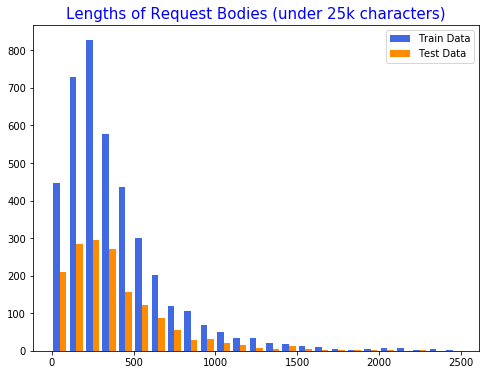

In [4]:
# Use some subsequent cells to show distributions across the train/test sets

# Find lengths of posts' body, title, and pizza success binary 
lengths_of_request_text = []
test_lengths_of_request_text = []
pizza_success = []

n = 0
for i in df_train['request_text_edit_aware']:
    lengths_of_request_text.append(len(i))
    if df_train['requester_received_pizza'][n] == True:
        pizza_success.append(1)
    else:
        pizza_success.append(0)
    n+=1

n = 0
for i in df_test['request_text_edit_aware']: 
    test_lengths_of_request_text.append(len(i))
    n+=1

# Count zero-character request bodies
c = 0
for i in lengths_of_request_text:
    if i == 0:
        c+=1
c2 = 0
for i in test_lengths_of_request_text:
    if i == 0:
        c2+=1

print("Number of requests with no body in TRAIN DATA:", c)
print("Ratio of requests with no body in TRAIN DATA:", np.round(c/len(lengths_of_request_text), 3))
print("\nNumber of requests with no body in TRAIN DATA:", c2)
print("Ratio of requests with no body in TRAIN DATA:", np.round(c2/len(test_lengths_of_request_text), 3), "\n")

#Show overall distribution of request body and title lengths
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist([np.array(lengths_of_request_text)[[np.where(np.array(lengths_of_request_text) < 2500)]][0], 
          np.array(test_lengths_of_request_text)[[np.where(np.array(test_lengths_of_request_text) < 2500)]][0]], 
          bins=25,
          color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"])
ax.set_title("Lengths of Request Bodies (under 25k characters)", color='blue', size=15)

Text(0, 0.5, 'Success Rate')

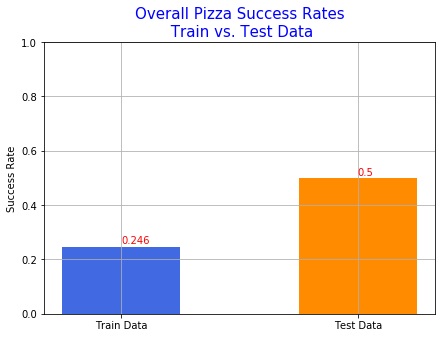

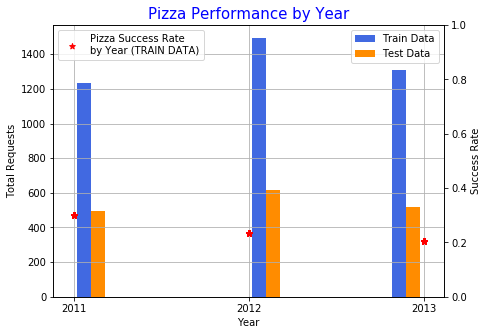

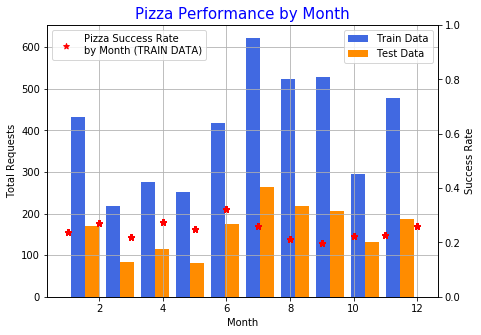

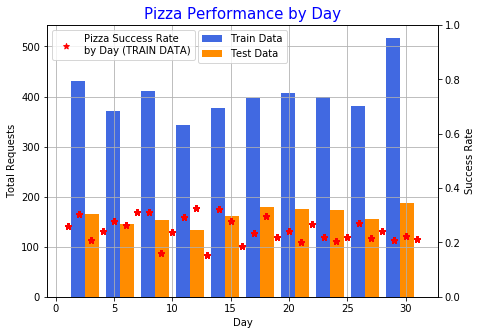

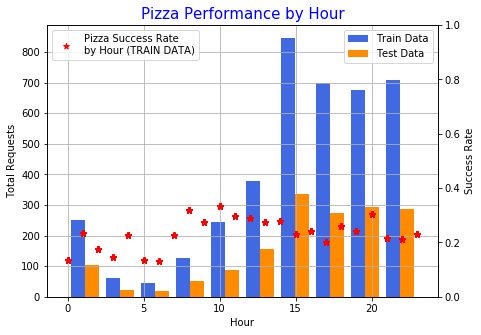

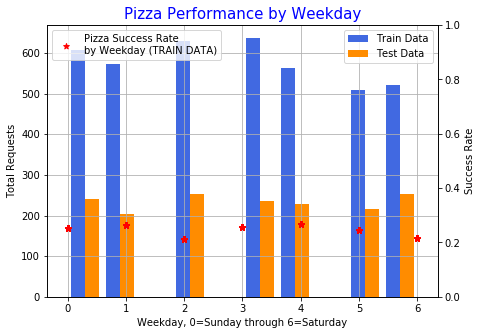

In [5]:
# Show discrepancy between pizza success rates in train vs. test data
train_data_pizza_success_rate = df_train['requester_received_pizza'][df_train['requester_received_pizza'] == True].count()/(df_train['requester_received_pizza'].count())
test_data_pizza_success_rate = .5
data = [np.round(train_data_pizza_success_rate, 3), np.round(test_data_pizza_success_rate, 3)]
labels = ['Train Data', 'Test Data']

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.grid()
ax.bar(labels, data, color=['royalblue', 'darkorange'], width=.5)
ax.set_ylim((0,1))
ax.set_title('Overall Pizza Success Rates\n Train vs. Test Data', color='blue', size=15)
ax.set_ylabel('Success Rate')
ax.annotate(data[0], xy=(0, .26), color='red')
ax.annotate(data[1], xy=(1, .51), color='red')

# Convert UTC time of request to atomic parts of time (down to hour)
year_of_request = []
month_of_request = []
day_of_request = []
hour_of_request = []
wkdy_of_request = []

for i in df_train['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    year_of_request.append(timestamp.strftime('%Y'))
    month_of_request.append(int(timestamp.strftime('%m')))
    day_of_request.append(int(timestamp.strftime('%d')))
    hour_of_request.append(int(timestamp.strftime('%H')))
    wkdy_of_request.append(int(timestamp.strftime('%w')))

# Calculate and store success rates by year and month
success_rate_by_year = []
for i in range(0,3):
    year_total = np.array(year_of_request)[np.where(np.array(year_of_request) == np.unique(np.array(year_of_request))[i])].size
    pizza_successes_in_year = np.sum(np.array(pizza_success)[np.where(np.array(year_of_request) == np.unique(np.array(year_of_request))[i])])
    success_rate_by_year.append(pizza_successes_in_year/year_total)

success_rate_by_month = []
for i in range(0,12):
    month_total = np.array(month_of_request)[np.where(np.array(month_of_request) == np.unique(np.array(month_of_request))[i])].size
    pizza_successes_in_month = np.sum(np.array(pizza_success)[np.where(np.array(month_of_request) == np.unique(np.array(month_of_request))[i])])
    success_rate_by_month.append(pizza_successes_in_month/month_total)

success_rate_by_day = []
for i in range(0,31):
    day_total = np.array(day_of_request)[np.where(np.array(day_of_request) == np.unique(np.array(day_of_request))[i])].size
    pizza_successes_in_day = np.sum(np.array(pizza_success)[np.where(np.array(day_of_request) == np.unique(np.array(day_of_request))[i])])
    success_rate_by_day.append(pizza_successes_in_day/day_total)

success_rate_by_hour = []
for i in range(0,24):
    hour_total = np.array(hour_of_request)[np.where(np.array(hour_of_request) == np.unique(np.array(hour_of_request))[i])].size
    pizza_successes_in_hour = np.sum(np.array(pizza_success)[np.where(np.array(hour_of_request) == np.unique(np.array(hour_of_request))[i])])
    success_rate_by_hour.append(pizza_successes_in_hour/hour_total)
    
success_rate_by_wkdy = []
for i in range(0,7):
    wkdy_total = np.array(wkdy_of_request)[np.where(np.array(wkdy_of_request) == np.unique(np.array(wkdy_of_request))[i])].size
    pizza_successes_in_wkdy = np.sum(np.array(pizza_success)[np.where(np.array(wkdy_of_request) == np.unique(np.array(wkdy_of_request))[i])])
    success_rate_by_wkdy.append(pizza_successes_in_wkdy/wkdy_total)

success_rate_by_year_to_plot = []
for i in year_of_request:
    if i == '2011':
        success_rate_by_year_to_plot.append(success_rate_by_year[0])
    elif i == '2012':
        success_rate_by_year_to_plot.append(success_rate_by_year[1])
    elif i == '2013':
        success_rate_by_year_to_plot.append(success_rate_by_year[2])

success_rate_by_month_to_plot = []
for i in month_of_request:
    for r in range(1,13):
        if i == r:
            success_rate_by_month_to_plot.append(success_rate_by_month[r-1])

success_rate_by_day_to_plot = []
for i in day_of_request:
    for r in range(1,32):
        if i == r:
            success_rate_by_day_to_plot.append(success_rate_by_day[r-1])

success_rate_by_hour_to_plot = []
for i in hour_of_request:
    for r in range(0,24):
        if i == r:
            success_rate_by_hour_to_plot.append(success_rate_by_hour[r])

success_rate_by_wkdy_to_plot = []
for i in wkdy_of_request:
    for r in range(0,7):
        if i == r:
            success_rate_by_wkdy_to_plot.append(success_rate_by_wkdy[r])

test_year_of_request = []
test_month_of_request = []
test_day_of_request = []
test_hour_of_request = []
test_wkdy_of_request = []

for i in df_test['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    test_year_of_request.append(timestamp.strftime('%Y'))
    test_month_of_request.append(int(timestamp.strftime('%m')))
    test_day_of_request.append(int(timestamp.strftime('%d')))
    test_hour_of_request.append(int(timestamp.strftime('%H')))
    test_wkdy_of_request.append(int(timestamp.strftime('%w')))

# Show distributions for train and test data
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist([year_of_request, test_year_of_request], color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"])
ax.grid()
ax.set_title("Pizza Performance by Year", color='blue', size=15)
ax.set_xlabel("Year")
ax.set_ylabel("Total Requests")
ax2 = ax.twinx()
ax2.scatter(year_of_request, success_rate_by_year_to_plot, color='red', label="Pizza Success Rate\nby Year (TRAIN DATA)", marker="*")
ax2.legend(loc=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Success Rate")

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist([month_of_request, test_month_of_request], color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"])
ax.grid()
ax.set_title("Pizza Performance by Month", color='blue', size=15)
ax.set_xlabel("Month")
ax.set_ylabel("Total Requests")
ax2 = ax.twinx()
ax2.scatter(np.array(month_of_request), np.array(success_rate_by_month_to_plot), color='red', label="Pizza Success Rate\nby Month (TRAIN DATA)", marker="*")
ax2.legend(loc=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Success Rate")

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist([day_of_request, test_day_of_request], color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"], loc=9)
ax.grid()
ax.set_title("Pizza Performance by Day", color='blue', size=15)
ax.set_xlabel("Day")
ax.set_ylabel("Total Requests")
ax2 = ax.twinx()
ax2.scatter(np.array(day_of_request), np.array(success_rate_by_day_to_plot), color='red', label="Pizza Success Rate\nby Day (TRAIN DATA)", marker="*")
ax2.legend(loc=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Success Rate")

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist([hour_of_request, test_hour_of_request], color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"])
ax.grid()
ax.set_title("Pizza Performance by Hour", color='blue', size=15)
ax.set_xlabel("Hour")
ax.set_ylabel("Total Requests")
ax2 = ax.twinx()
ax2.scatter(np.array(hour_of_request), np.array(success_rate_by_hour_to_plot), color='red', label="Pizza Success Rate\nby Hour (TRAIN DATA)", marker="*")
ax2.legend(loc=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Success Rate")

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist([wkdy_of_request, test_wkdy_of_request], color=['royalblue', 'darkorange'])
ax.legend(["Train Data", "Test Data"])
ax.grid()
ax.set_title("Pizza Performance by Weekday", color='blue', size=15)
ax.set_xlabel("Weekday, 0=Sunday through 6=Saturday")
ax.set_ylabel("Total Requests")
ax2 = ax.twinx()
ax2.scatter(np.array(wkdy_of_request), np.array(success_rate_by_wkdy_to_plot), color='red', label="Pizza Success Rate\nby Weekday (TRAIN DATA)", marker="*")
ax2.legend(loc=2)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Success Rate")

Text(1, 0.23, '0.222')

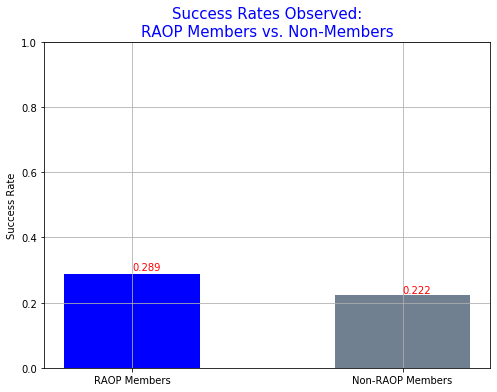

In [6]:
# Derive RAOP subreddit membership from other field
RAOP_member_at_time_of_request = []
for r in df_train['requester_subreddits_at_request']:
    if 'Random_Acts_Of_Pizza' in r:
        if "RandomActsOfPizza" not in r:
            RAOP_member_at_time_of_request.append(1)
        else:
            RAOP_member_at_time_of_request.append(1)
    elif "RandomActsOfPizza" in r:
        if 'Random_Acts_Of_Pizza' not in r:
            RAOP_member_at_time_of_request.append(1)
    else:
        RAOP_member_at_time_of_request.append(0)

# create column in dataframe
df_train['RAOP_member_at_time_of_request'] = RAOP_member_at_time_of_request

RAOP_members_success_rate = df_train['RAOP_member_at_time_of_request'][df_train['requester_received_pizza'] == True][df_train['RAOP_member_at_time_of_request'] == 1].count() / df_train['RAOP_member_at_time_of_request'][df_train['RAOP_member_at_time_of_request'] == 1].count()

Non_RAOP_members_success_rate = df_train['RAOP_member_at_time_of_request'][df_train['requester_received_pizza'] == True][df_train['RAOP_member_at_time_of_request'] == 0].count() / df_train['RAOP_member_at_time_of_request'][df_train['RAOP_member_at_time_of_request'] == 0].count() 

# Show discrepancy between pizza success rates across RAOP members and non-members
data = [np.round(RAOP_members_success_rate, 3), np.round(Non_RAOP_members_success_rate, 3)]
labels = ['RAOP Members', 'Non-RAOP Members']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.grid()
ax.bar(labels, data, color=['blue', 'slategray'], width=.5)
ax.set_ylim((0,1))
ax.set_title('Success Rates Observed:\nRAOP Members vs. Non-Members', color='blue', size=15)
ax.set_ylabel('Success Rate')
ax.annotate(data[0], xy=(0, .3), color='red')
ax.annotate(data[1], xy=(1, .23), color='red')

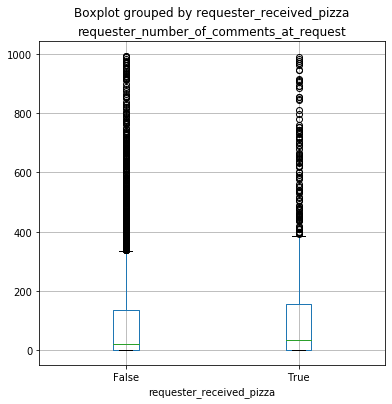

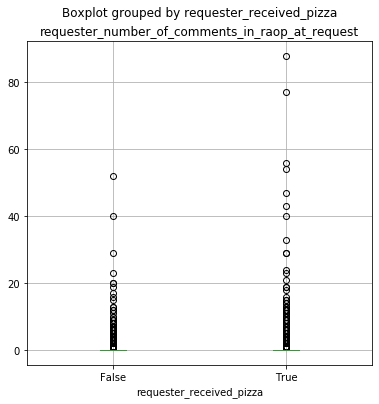

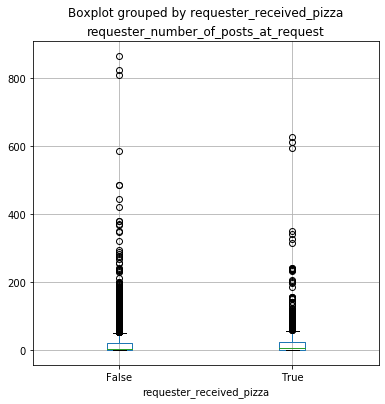

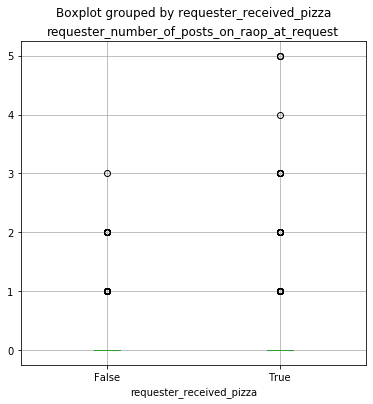

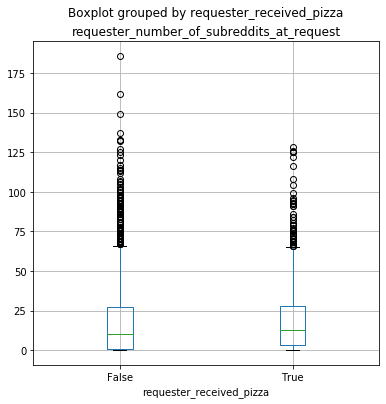

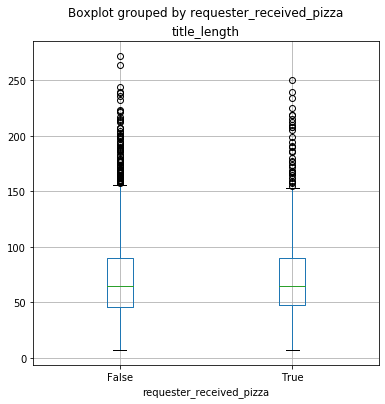

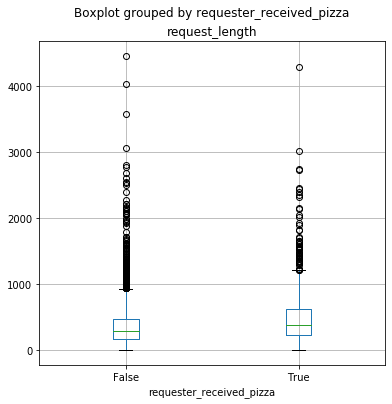

In [7]:
# Show how the data differs (or doesn't) between successful and unsuccessful pizza posts
# Redid this with only columns that exist in test data
# Variable transformation
df_train['title_length'] = df_train.request_title.str.len()
df_train['request_length'] = df_train.request_text_edit_aware.str.len()


boxplot_df = df_train[['requester_received_pizza', 'requester_number_of_comments_at_request',
                      'requester_number_of_comments_in_raop_at_request',
                      'requester_number_of_posts_at_request', 'requester_number_of_posts_on_raop_at_request',
                      'requester_number_of_subreddits_at_request', 'title_length', 'request_length']]

for i, column in enumerate(boxplot_df):
    if column != 'requester_received_pizza':
        fig, ax = plt.subplots(figsize=(6,6))
        bplot = boxplot_df.boxplot([column], by='requester_received_pizza', ax=ax)
        bplot.axes.set_title(column)
        plt.show()

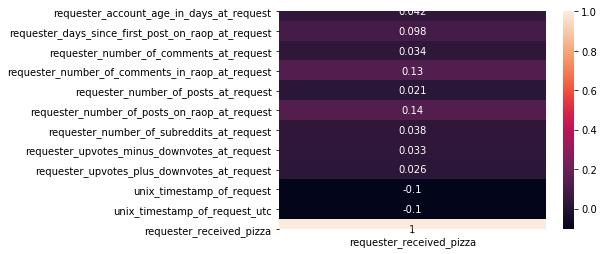

In [8]:
df_train_testcols = df_train[['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 
          'requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 
          'requester_number_of_comments_at_request', 'requester_number_of_comments_in_raop_at_request', 
          'requester_number_of_posts_at_request', 'requester_number_of_posts_on_raop_at_request', 
          'requester_number_of_subreddits_at_request', 'requester_subreddits_at_request', 
          'requester_upvotes_minus_downvotes_at_request', 'requester_upvotes_plus_downvotes_at_request', 
          'requester_username', 'unix_timestamp_of_request', 'unix_timestamp_of_request_utc','requester_received_pizza']]

corrMatrix = df_train_testcols.corr()
corrPizza = corrMatrix[['requester_received_pizza']]
sn.heatmap(corrPizza, annot = True)

## Promising Features (so far)

### Natural Features

Based on the EDA, some of the promising features so far look to be:
* age of the account
* requester number of posts
* requester number of comments

However, these variable may not be independent so we most likely do not want to use all of them.

In [9]:
# looking at top correlations 
corrPizza.sort_values('requester_received_pizza', ascending=False)

requester_received_pizza
requester_received_pizza                                            1.000000
requester_number_of_posts_on_raop_at_request                        0.137208
requester_number_of_comments_in_raop_at_request                     0.131296
requester_days_since_first_post_on_raop_at_request                  0.098225
requester_account_age_in_days_at_request                            0.041784
requester_number_of_subreddits_at_request                           0.037647
requester_number_of_comments_at_request                             0.033779
requester_upvotes_minus_downvotes_at_request                        0.032571
requester_upvotes_plus_downvotes_at_request                         0.026102
requester_number_of_posts_at_request                                0.020612
unix_timestamp_of_request_utc                                      -0.103346
unix_timestamp_of_request                                          -0.103348

The most promising features based on the correlation matrix are:
* requester_number_of_posts_on_raop_at_request
* requester_number_of_comments_in_raop_at_request
* requester_days_since_first_post_on_raop_at_request

While **requester_days_since_first_post_on_raop_at_request** and **requester_number_of_comments_in_raop_at_request** are highly correlated with each other, **requester_number_of_posts_on_raop_at_request** is less correlated with the other two features. 

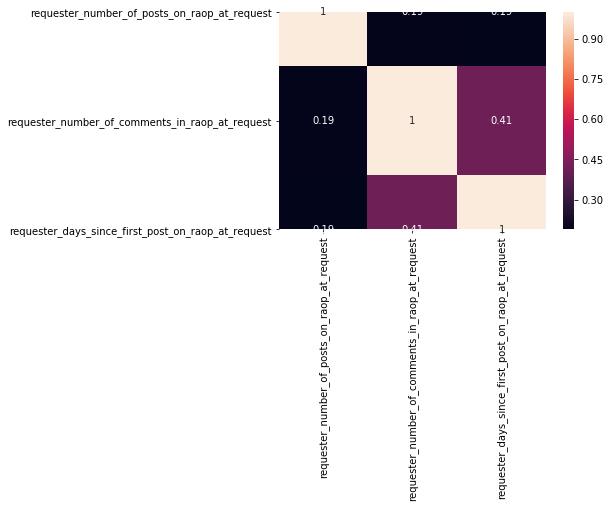

In [10]:
df_test_raop = df_test[['requester_number_of_posts_on_raop_at_request', 'requester_number_of_comments_in_raop_at_request',
        'requester_days_since_first_post_on_raop_at_request']]

corrMatrix_raop = df_test_raop.corr()
sn.heatmap(corrMatrix_raop, annot = True)

The next 6 items are correlated with each other with correlation coefficients of at least 0.25. These numbers typically increase as a user's account ages. We can choose one of them and move forward.

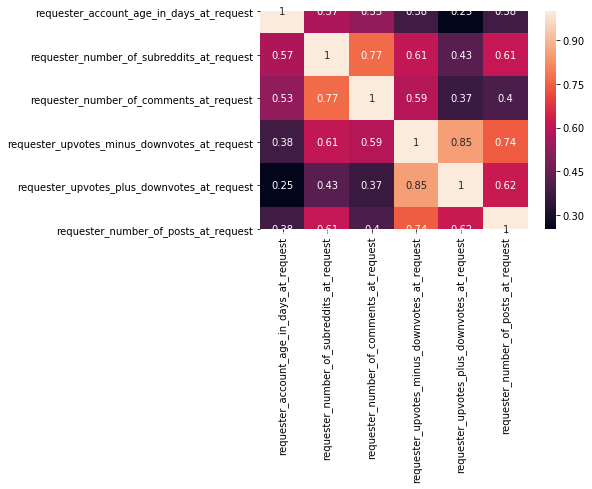

In [11]:
df_test_new = df_test[['requester_account_age_in_days_at_request', 'requester_number_of_subreddits_at_request', 
                       'requester_number_of_comments_at_request', 'requester_upvotes_minus_downvotes_at_request', 
                       'requester_upvotes_plus_downvotes_at_request', 'requester_number_of_posts_at_request']]

corrMatrix_new = df_test_new.corr()
sn.heatmap(corrMatrix_new, annot = True)

We can also extract data from the timestamps and use those to predict a cheesy bequest. Year of post is predictive. It declines year over year. Day of month doesn’t look very strong, but first half/last half makes difference. Hour of the day also seems to have a relationship with whether pizza is gifted.

Other things we can extract from the post that may be good features are:
* The length of the body 
* Images 
* money keywords

### Feature Engineering

Based on the EDA.  Some of the additional features we'd like to add are:\
*does the post contain an image\
*topic of the post\
*length of the post\
*timing within a month (first half or last half)

In [12]:
# Convert UTC time of request to atomic parts of time (down to hour)
year_of_request = []
month_of_request = []
day_of_request = []
hour_of_request = []
for i in df_train['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    year_of_request.append(timestamp.strftime('%Y'))
    month_of_request.append(int(timestamp.strftime('%m')))
    day_of_request.append(int(timestamp.strftime('%d')))
    hour_of_request.append(int(timestamp.strftime('%H')))

#Adding binarized first half of month to train data
first_half_of_month = []
for d in day_of_request:
    if d <= 15:
        first_half_of_month.append(1)
    else:
        first_half_of_month.append(0)

df_train['first_half_of_month'] = first_half_of_month

test_year_of_request = []
test_month_of_request = []
test_day_of_request = []
test_hour_of_request = []

for i in df_test['unix_timestamp_of_request_utc']:
    timestamp = datetime.datetime.fromtimestamp(i)
    test_year_of_request.append(timestamp.strftime('%Y'))
    test_month_of_request.append(int(timestamp.strftime('%m')))
    test_day_of_request.append(int(timestamp.strftime('%d')))
    test_hour_of_request.append(int(timestamp.strftime('%H')))

#Adding binarized first half of month to test data
test_first_half_of_month = []
for d in test_day_of_request:
    if d <= 15:
        test_first_half_of_month.append(1)
    else:
        test_first_half_of_month.append(0)

df_test['first_half_of_month'] = test_first_half_of_month

# Binarize the hours for modeling

zero_to_three = []
four_to_seven = []
eight_to_eleven = []
twelve_to_fifteen = []
sixteen_to_nineteen = []
twenty_to_twentythree = []

for h in hour_of_request:
    if h in [0, 1, 2, 3]:
        zero_to_three.append(1)
    else:
        zero_to_three.append(0)
    if h in [4, 5, 6, 7]:
        four_to_seven.append(1)
    else:
        four_to_seven.append(0)
    if h in [8, 9, 10, 11]:
        eight_to_eleven.append(1)
    else:
        eight_to_eleven.append(0)
    if h in [12, 13, 14, 15]:
        twelve_to_fifteen.append(1)
    else:
        twelve_to_fifteen.append(0)
    if h in [16, 17, 18, 19]:
        sixteen_to_nineteen.append(1)
    else:
        sixteen_to_nineteen.append(0)
    if h in [20, 21, 22, 23]:
        twenty_to_twentythree.append(1)
    else:
        twenty_to_twentythree.append(0)

# Push into the train dataframe each of these
df_train['zero_to_three'] = zero_to_three
df_train['four_to_seven'] = four_to_seven
df_train['eight_to_eleven'] = eight_to_eleven
df_train['twelve_to_fifteen'] = twelve_to_fifteen
df_train['sixteen_to_nineteen'] = sixteen_to_nineteen
df_train['twenty_to_twentythree'] = twenty_to_twentythree

test_zero_to_three = []
test_four_to_seven = []
test_eight_to_eleven = []
test_twelve_to_fifteen = []
test_sixteen_to_nineteen = []
test_twenty_to_twentythree = []

for h in test_hour_of_request:
    if h in [0, 1, 2, 3]:
        test_zero_to_three.append(1)
    else:
        test_zero_to_three.append(0)
    if h in [4, 5, 6, 7]:
        test_four_to_seven.append(1)
    else:
        test_four_to_seven.append(0)
    if h in [8, 9, 10, 11]:
        test_eight_to_eleven.append(1)
    else:
        test_eight_to_eleven.append(0)
    if h in [12, 13, 14, 15]:
        test_twelve_to_fifteen.append(1)
    else:
        test_twelve_to_fifteen.append(0)
    if h in [16, 17, 18, 19]:
        test_sixteen_to_nineteen.append(1)
    else:
        test_sixteen_to_nineteen.append(0)
    if h in [20, 21, 22, 23]:
        test_twenty_to_twentythree.append(1)
    else:
        test_twenty_to_twentythree.append(0)

# Push into the train dataframe each of these
df_test['zero_to_three'] = test_zero_to_three
df_test['four_to_seven'] = test_four_to_seven
df_test['eight_to_eleven'] = test_eight_to_eleven
df_test['twelve_to_fifteen'] = test_twelve_to_fifteen
df_test['sixteen_to_nineteen'] = test_sixteen_to_nineteen
df_test['twenty_to_twentythree'] = test_twenty_to_twentythree


In [13]:
test_RAOP_member_at_time_of_request = []
for r in df_test['requester_subreddits_at_request']:
    if 'Random_Acts_Of_Pizza' in r:
        if "RandomActsOfPizza" not in r:
            test_RAOP_member_at_time_of_request.append(1)
        else:
            test_RAOP_member_at_time_of_request.append(1)
    elif "RandomActsOfPizza" in r:
        if 'Random_Acts_Of_Pizza' not in r:
            test_RAOP_member_at_time_of_request.append(1)
    else:
        test_RAOP_member_at_time_of_request.append(0)

# Adding binary here into the dataframe for ease later
df_test['RAOP_member_at_time_of_request'] = test_RAOP_member_at_time_of_request

In [14]:
df_train['request_title_text'] = df_train['request_title'] + df_train['request_text_edit_aware']

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bees'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


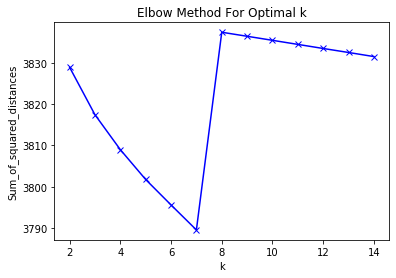

In [15]:
### cluster analysis
### vectorize the request text using tf-idf and remove hyperlinks and images
### remove stopwords


def tokenize(text):
    new_s = re.sub(r'\_',' ',text)
    new_s = re.sub(r'[^\w\s]',' ',new_s)
    tokens = nltk.word_tokenize(new_s)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

def preprocessor(s):
    # convert all letters to lower cases and remove non-letter characters
    new_s = s.lower()
    new_s = re.sub(r'\_',' ',new_s)
    new_s = re.sub(r'[^\w\s]',' ',new_s)
    new_s = re.sub(r'(http|com|www)', '', new_s)
    new_s = re.sub(r'(imgur|jpg|png|picture|pic|youtube)', '', new_s)
    return new_s

stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone",
             "able", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", 
             "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back",
             "be", "became", "because","become","becomes", "becoming", "been", "bee", "bees" "before", "beforehand", "behind", 
             "being", "below", "beside", "besides", "between", "beyond", "both", "bottom","but", "by", "call", "can", 
             "cannot", "cant", "co", "con", "could", "couldnt", "de", "describe", "detail", "do", "done", "don", "down", "due",
             "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "enough", "etc", "even", "ever", "every", 
             "everyone", "everything", "everywhere", "except", "es", "few", "fill", "find", "fire", "first", "for", "found", 
             "from", "front", "full", "further", "get", "got", "give", "going", "go", "had", "has", "hasnt", "have", "he", 
             "hence", "her", "here", "hers", "herself", "hey", "hi", "him", "himself", "his", "how", "however", "ie", "if", 
             "in", "inc", "indeed", "into", "is", "it", "its", "im", "ll", "till", "i", "itself", "just",  "keep", "ltd", "link",
             "last", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", 
             "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", 
             "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", 
             "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", 
             "per", "perhaps", "please", "put", "rather", "re", "really", "reddit", "request", "same", "see", "seem", 
             "seemed", "seeming", "seems","several", "she", "should", "show", "side", "since", "sincere", "so", "some",
             "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "than", "that", "the", 
             "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", 
             "thereupon", "these", "they", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", 
             "together", "too", "top", "toward", "towards", "un", "under", "until", "up", "upon", "us", "ve", "very", "via", 
             "was", "we", "well", "were", "what", "whatever", "when", "whenever", "where", "whereafter", "whereas", "whereby",
             "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom",
             "whose",  "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", 
             "yourselves"]

vectorizer = TfidfVectorizer(stop_words=stopwords, preprocessor = preprocessor)
X = vectorizer.fit_transform(df_train['request_text_edit_aware'])
sum_of_squared_dist = []
K = range(2,15)

for k in K:
    model = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    model.fit(X)
    sum_of_squared_dist.append(model.inertia_)

plt.plot(K, sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [16]:
print(X.shape)

(4040, 12254)


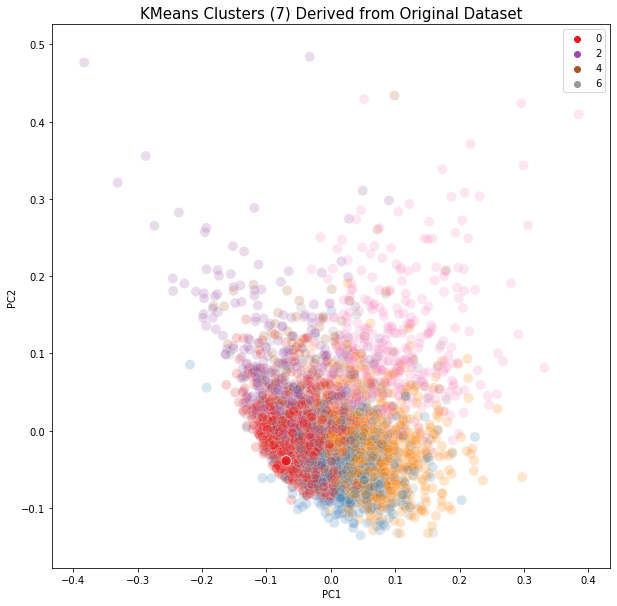

In [17]:
# use PCA to reduce dimensionality
# import sys
# !conda install --yes plotly
# ref: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6
kmeans =KMeans(n_clusters = 7, init='k-means++', max_iter=100, n_init=1, random_state=0).fit(X)
labels = kmeans.labels_

pca = PCA().fit(X.toarray())
pca_2d = pca.transform(X.toarray())

plt.figure(figsize = (10,10))
sns.scatterplot(pca_2d[:,0], pca_2d[:,1], 
                hue=labels, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (7) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()


Three of the 7 clusters congested in the center. (purple, gray and brown)
By ploting the clusters into a 3D space below, we are still unable to distinct the three clusters.

In [18]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
trace = go.Scatter3d(x=pca_2d[:,0], y=pca_2d[:,1], z=pca_2d[:,2], mode='markers',
                     marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()
 

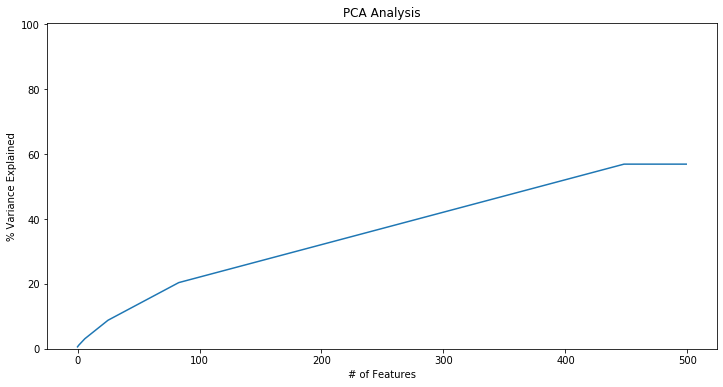

In [19]:
# feature reduction via PCA
pca = PCA(n_components=500)
pca.fit(X.toarray())
variance = pca.explained_variance_ratio_
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(np.cumsum(np.round(variance, 3)*100))

pca = PCA(n_components=450)
pca_scale = pca.fit_transform(X.toarray())
pca_df_scale = pd.DataFrame(pca_scale, columns=['pc' + str(i) for i in range(1,451)])
#print(pca.explained_variance_ratio_)


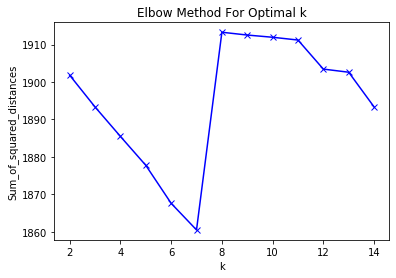

In [20]:
sum_of_squared_dist = []
K = range(2,15)

for k in K:
    model = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    model.fit(pca_scale)
    sum_of_squared_dist.append(model.inertia_)

plt.plot(K, sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

SSE starts to diminish after 5. Hence, we determine the optimal K is 5.

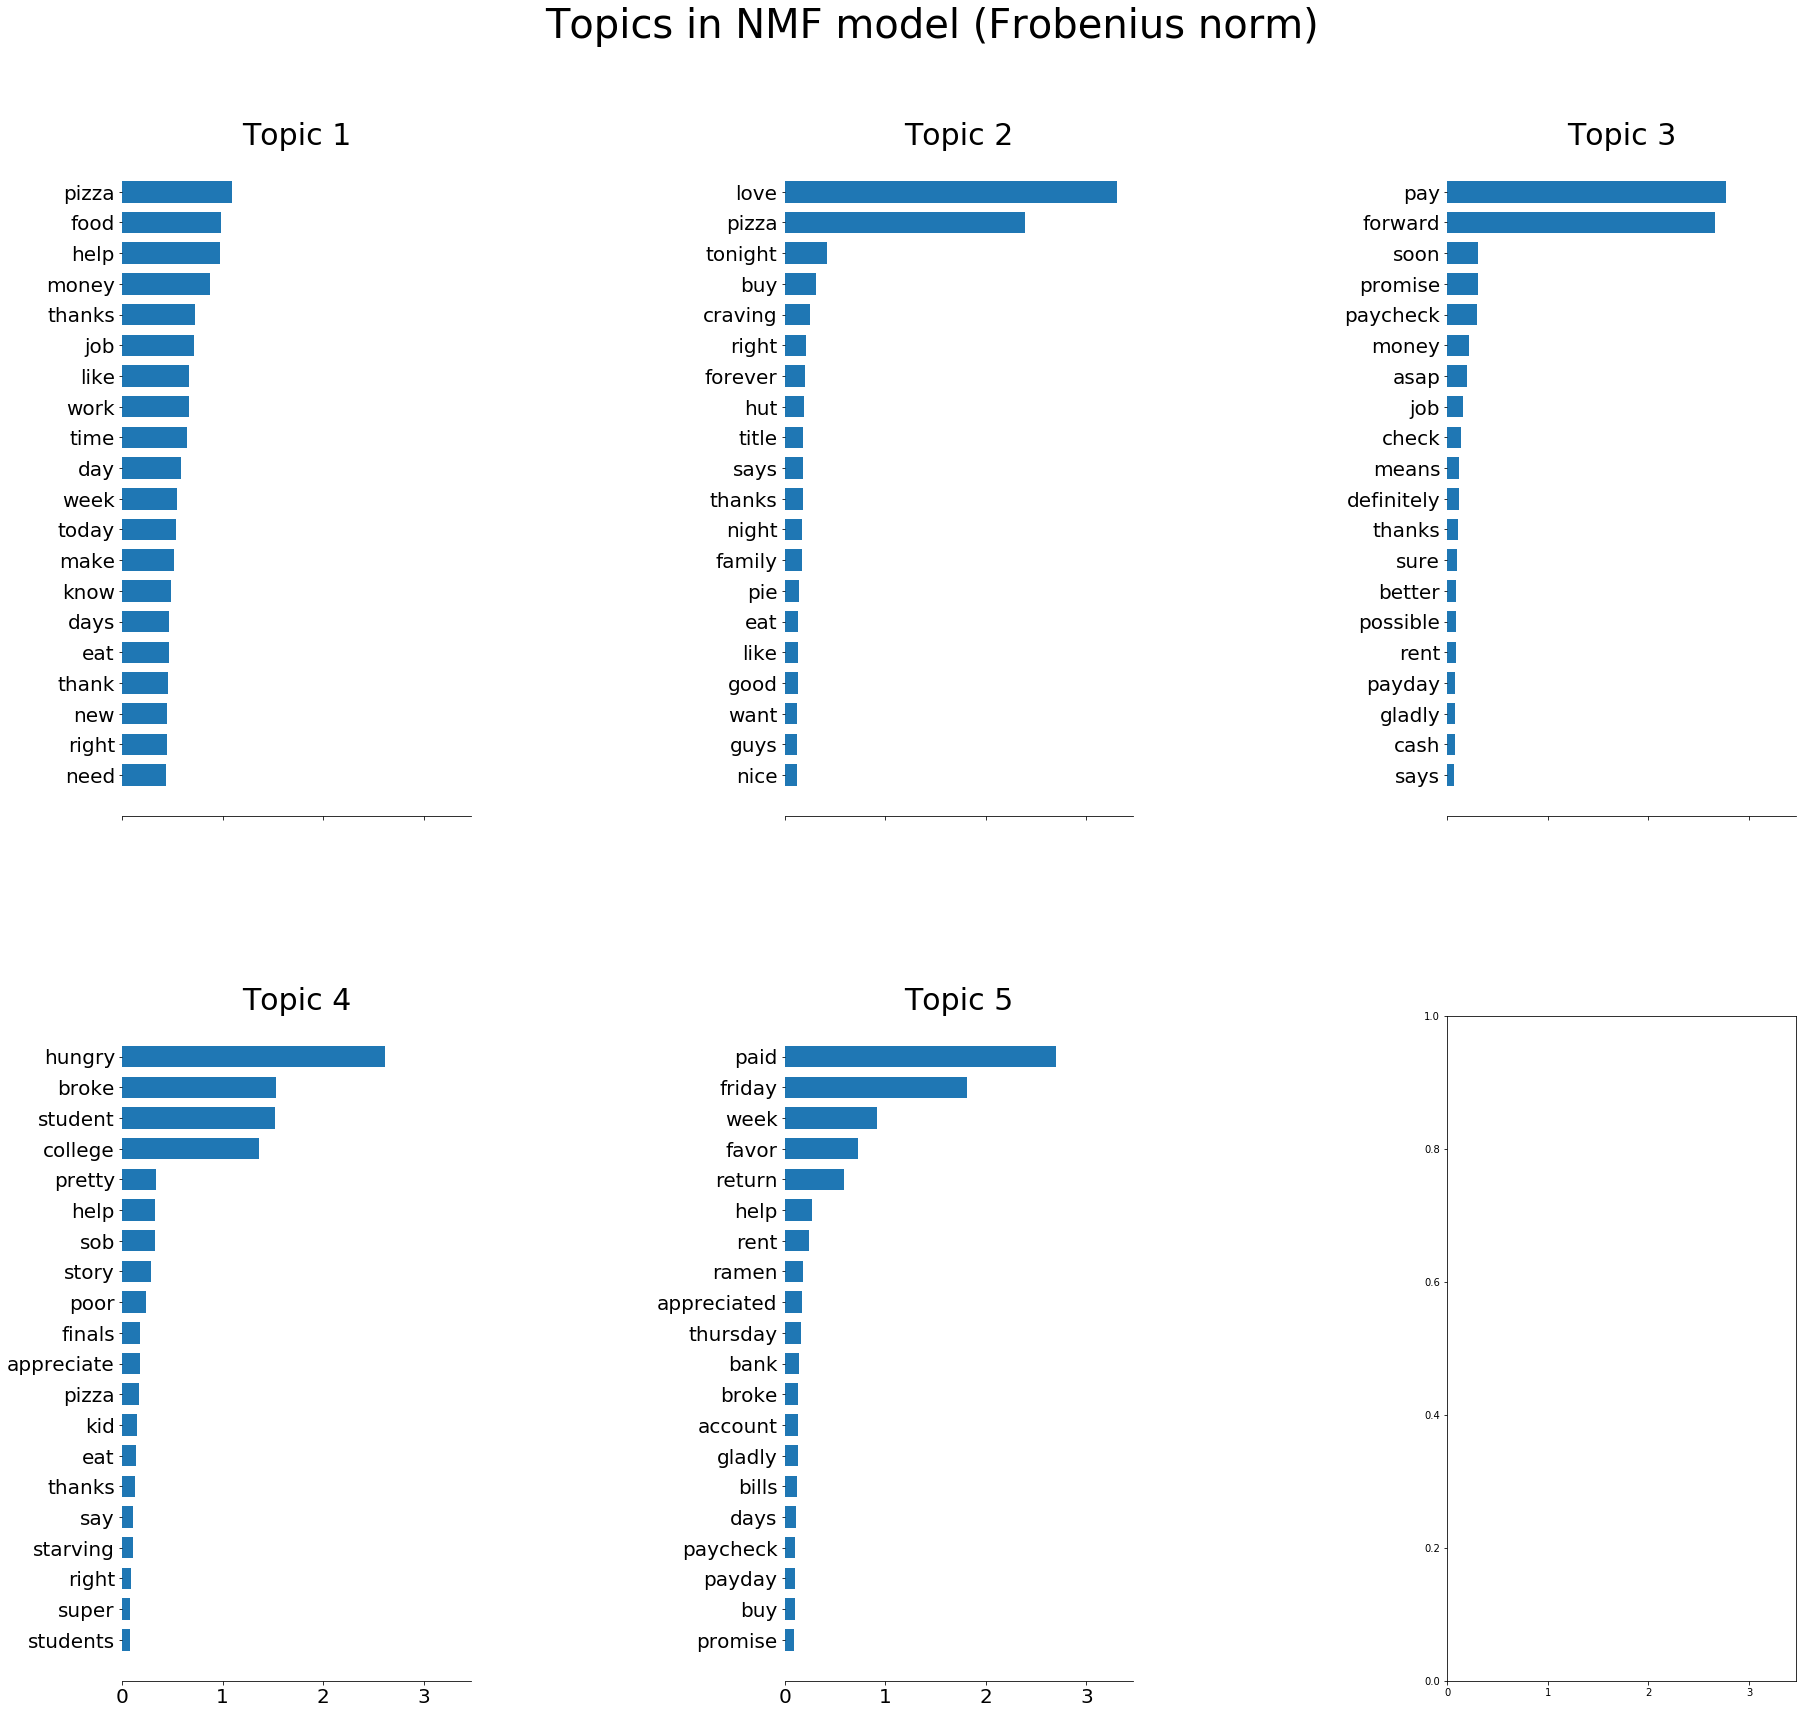

In [21]:
## NMF

n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Fit the NMF model 1
nmf = NMF(n_components=n_components, random_state=0,
          alpha=.1, l1_ratio=.5).fit(X)
nmf_topic_values = nmf.transform(X)
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')


    


In [22]:
topic_feature_dict = []
for topic_idx, topic in enumerate(nmf.components_):
    top_features_ind = topic.argsort()[:-n_top_words*2 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    topic_feature_dict.append(top_features[:])    


Topic 1: Job

Topic 2: Craving 

Topic 3: Financial difficulty / Pay forward

Topic 4: Students

Topic 5: Financial difficulty / Reciprocity

In [23]:
word_count = np.zeros((df_train.shape[0],n_components))
for i in range(n_components):
    words_re = '|'.join(topic_feature_dict[i])
    words_re = "r'" + words_re + "'"
    for j, text in enumerate(df_train['request_title_text']):
        text = text.lower()
        text = re.sub(r'\_',' ',text)
        text = re.sub(r'[^\w\s]',' ',text)
        word_count[j, i] = pd.Series(text.split()).str.contains(words_re).sum()
        
    

In [24]:
word_count_df = pd.DataFrame(word_count, columns=list(['Topic1_count','Topic2_count', 'Topic3_count',
                                                       'Topic4_count', 'Topic5_count']))
df_train = pd.concat([df_train, word_count_df], axis=1)

In [25]:
# check NMF error
#ref:https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f

In [26]:
# Use NMF model to assign topic to training posts
df_train['NMF_topic'] = nmf_topic_values.argmax(axis=1)

In [27]:
# Logistic regression model
LogReg_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class="auto")
LogReg_model.fit(X, df_train['NMF_topic'])

# Access predicted probabilities
predict_prob = LogReg_model.predict_proba(X)

for i in range(predict_prob.shape[1]):
    df_train['Topic'+ str(i + 1) +'_prob'] = predict_prob[:,i]


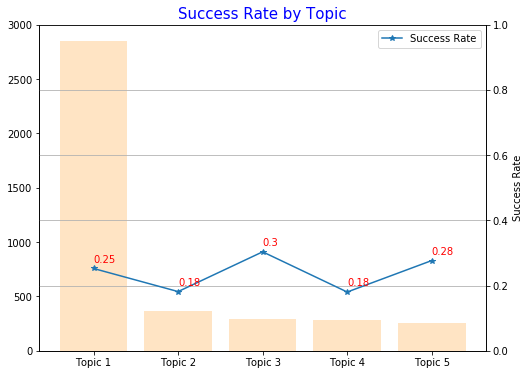

In [28]:
# Successful rate for each topic
labels = []
SR = []
total = []
for i in range(n_components):
    labels.append("Topic "+ str(i+1))
    total.append(df_train[df_train['NMF_topic'] == i].shape[0])
    SR.append(float(df_train[(df_train['NMF_topic'] == i) & (df_train['requester_received_pizza'] == True)].shape[0])/
              df_train[df_train['NMF_topic'] == i].shape[0])

fig = plt.figure(figsize=(8,6))
plt.bar(range(n_components), total, color='bisque', label='Number of requests')
plt.ylim(0, 3000)
ax = plt.twinx()
ax.grid()

ax.plot(labels, SR, label='Success Rate', marker='*')
ax.set_ylim(0, 1)
ax.set_title('Success Rate by Topic', color='blue', size=15)
for i in range(n_components):
    ax.annotate(round(SR[i],2), xy=(i, SR[i]+0.02), color='red')

ax.set_ylabel('Success Rate')
ax.legend()

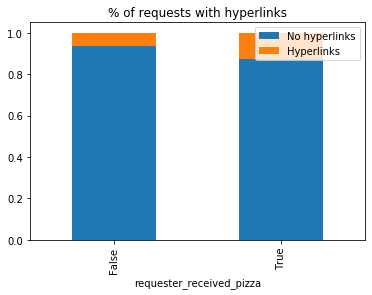

                              ones          
includes_hyperlink               0         1
requester_received_pizza                    
False                     0.934340  0.065660
True                      0.875252  0.124748


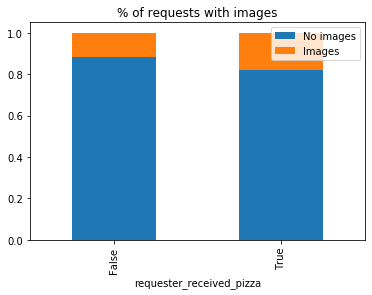

                              ones          
includes_visuals                 0         1
requester_received_pizza                    
False                     0.883782  0.116218
True                      0.819920  0.180080


In [29]:
# # Requests include images
visual = re.compile(r'(imgur\.com|\.jpg|png|picture|pic|youtube)', re.IGNORECASE)
visual_count = df_train['request_text_edit_aware'].apply(lambda x: len(visual.findall(x)))
df_train['includes_visuals'] = np.where(visual_count > 0,1,0)

# # Requests include hyperlinks
hyperlink = re.compile(r'http[s]?://\S+|www\.', re.IGNORECASE)
hyperlink_count = df_train['request_text_edit_aware'].apply(lambda x: len(hyperlink.findall(x)))
df_train['includes_hyperlink'] = np.where(hyperlink_count > 0,1,0)
df_train['ones'] = np.ones(df_train.shape[0])

transform_bp_df = df_train[['requester_received_pizza', 'includes_hyperlink', 'includes_visuals', 'ones']]

tps = transform_bp_df.pivot_table(values=['ones'], 
                      index='requester_received_pizza',
                      columns='includes_hyperlink',
                      aggfunc='count')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True)
plt.title('% of requests with hyperlinks')
plt.legend(['No hyperlinks', 'Hyperlinks'], loc='upper right')
plt.show()
print(tps)

tps = transform_bp_df.pivot_table(values=['ones'], 
                      index='requester_received_pizza',
                      columns='includes_visuals',
                      aggfunc='count')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True)
plt.title('% of requests with images')
plt.legend(['No images', 'Images'], loc='upper right')
plt.show()
print(tps)



In [30]:
# Sentiment analysis
# https://realpython.com/python-nltk-sentiment-analysis/
sia = SentimentIntensityAnalyzer()
req_polarity = [sia.polarity_scores(x) for x in df_train['request_text_edit_aware']]
sentiment_pos = [x['pos'] for x in req_polarity]
sentiment_neg = [x['neg'] for x in req_polarity]
sentiment_pos_neg = [(x['pos'], x['neg']) for x in req_polarity]
sentiment_bin = np.array([x[0]>x[1] for x in sentiment_pos_neg])
sentiment_bin = sentiment_bin.astype(int)


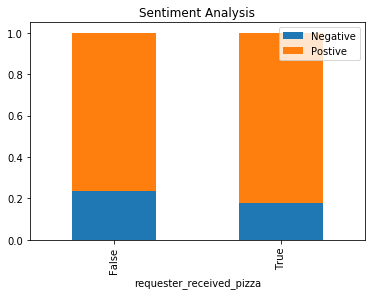

                              ones          
sentiment_bin                    0         1
requester_received_pizza                    
False                     0.235391  0.764609
True                      0.178068  0.821932


In [31]:
df_train['ones'] = np.ones(df_train.shape[0])
df_train['sentiment_bin'] = sentiment_bin

transform_bp_df = df_train[['requester_received_pizza', 'sentiment_bin', 'ones']]

tps = transform_bp_df.pivot_table(values=['ones'], 
                      index='requester_received_pizza',
                      columns='sentiment_bin',
                      aggfunc='count')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True)
plt.title('Sentiment Analysis')
plt.legend(['Negative', 'Postive'], loc='upper right')
plt.show()
print(tps)

In [32]:
# Convert frequency to decile between 0 and 1 for all topic features
for i in range(n_components):
    df_train['Topic'+ str(i + 1) +'_dec'] = pd.qcut(df_train['Topic'+ str(i + 1) +'_count'].rank(method='first'), 
                                                    q = 10, labels = False)

In [33]:
columns_for_modeling = ['requester_account_age_in_days_at_request', 
                        'requester_days_since_first_post_on_raop_at_request', 
                        'requester_number_of_comments_in_raop_at_request', 
                        'requester_number_of_posts_on_raop_at_request', 
                        'requester_upvotes_minus_downvotes_at_request', 
                        'request_length', # From here down are engineered features, not natural ones... must be matched in the test data
                        'RAOP_member_at_time_of_request', 
                        'zero_to_three', 
                        'four_to_seven', 
                        'eight_to_eleven', 
                        'twelve_to_fifteen', 
                        'sixteen_to_nineteen', 
                        'twenty_to_twentythree',
                        'first_half_of_month',
                        'includes_visuals',
                        'includes_hyperlink',
                        'Topic1_dec','Topic2_dec', 'Topic3_dec',
                        'Topic4_dec', 'Topic5_dec',
                        'sentiment_bin']

train_labels = np.where(df_train['requester_received_pizza'] == True,1,0)

In [34]:
# split into 80% training data and 20% dev data
train_data_split, dev_data, train_labels_split, dev_labels = train_test_split(
    df_train[columns_for_modeling], train_labels, test_size=0.2, random_state=42)

Xtrain, Xdev, train_labels_split, dev_labels = train_test_split(
    X, train_labels, test_size=0.2, random_state=42)


In [100]:
# KNN model
KNN_params = {'n_neighbors':range(1,11)}
clf_KNN = KNeighborsClassifier()
clf = GridSearchCV(clf_KNN, KNN_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
clf_KNN = KNeighborsClassifier(n_neighbors=10)
clf_KNN.fit(train_data_split, train_labels_split)
predictions_k = clf_KNN.predict(dev_data) #run model on development data
print("dev data accuracy:", accuracy_score(dev_labels, predictions_k))

Best parameters: {'n_neighbors': 10}
Best score: 0.7478341584158416
dev data accuracy: 0.7413366336633663


In [36]:
# Random Forest model
RF_params = {'criterion':('gini', 'entropy'), 'n_estimators':[100, 300, 500, 700, 1000, 2000], 'max_features':('sqrt','log2')}
clf_RF = RandomForestClassifier()
clf = GridSearchCV(clf_RF, RF_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
criterion_rf = clf.best_params_['criterion']
n_estimators_rf = clf.best_params_['n_estimators']
max_features_rf = clf.best_params_['max_features']
clf_RF = RandomForestClassifier(n_estimators=n_estimators_rf, criterion=criterion_rf, max_features=max_features_rf)
clf_RF.fit(train_data_split, train_labels_split)
predictions_RF = clf_RF.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_RF))

Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300}
Best score: 0.7626856435643564
dev data accuracy: 0.75


In [37]:
# Decision tree
DT_params = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'),
             'max_features':('sqrt','log2'), 'max_depth': [50, 40, 30, 20, 19, 18, 17, 16, 15, 10, 5],
            'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}
clf_DT = DecisionTreeClassifier()
clf = GridSearchCV(clf_DT, DT_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
criterion = clf.best_params_['criterion']
splitter = clf.best_params_['splitter']
max_features = clf.best_params_['max_features']
min_samples_leaf = clf.best_params_['min_samples_leaf']
max_depth = clf.best_params_['max_depth']
clf_DT = DecisionTreeClassifier(max_depth = max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf, 
                               splitter=splitter, max_features=max_features)
clf_DT.fit(train_data_split, train_labels_split)
predictions_DT = clf_DT.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_DT))

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 20, 'splitter': 'best'}
Best score: 0.7623762376237624
dev data accuracy: 0.7400990099009901


In [38]:
BaggingDT_params = {'n_estimators':[10, 100, 300, 500, 700, 1000, 2000]}
clf_BaggingDT = BaggingClassifier()
clf = GridSearchCV(clf_BaggingDT, BaggingDT_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)
n_estimators = clf.best_params_['n_estimators']
clf_BaggingDT = BaggingClassifier(n_estimators=n_estimators)
clf_BaggingDT.fit(train_data_split, train_labels_split)
predictions_BaggingDT = clf_BaggingDT.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_BaggingDT))

Best parameters: {'n_estimators': 700}
Best score: 0.7540222772277227
dev data accuracy: 0.7376237623762376


In [39]:
SVC_params = {'C':[1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0],
             'gamma': ('auto', 'scale')}
clf = GridSearchCV(SVC(), SVC_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

C = clf.best_params_['C']
gamma = clf.best_params_['gamma']
clf_SVC = SVC(C=C, gamma=gamma)
clf_SVC.fit(train_data_split, train_labels_split)
predictions_SVC = clf_SVC.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_SVC))

Best parameters: {'C': 1e-10, 'gamma': 'auto'}
Best score: 0.7577351485148515
dev data accuracy: 0.7388613861386139


In [40]:
LogReg_params = {'C':[1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
clf = GridSearchCV(LogisticRegression(solver="liblinear", multi_class="auto"), 
                   LogReg_params, scoring='accuracy', cv = 5)
clf.fit(train_data_split, train_labels_split)
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

C = clf.best_params_['C']
clf_LR = LogisticRegression(C=C, solver="liblinear", multi_class="auto")
clf_LR.fit(train_data_split, train_labels_split)
predictions_LR = clf_LR.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_LR))

Best parameters: {'C': 0.1}
Best score: 0.7639232673267327
dev data accuracy: 0.7512376237623762


In [41]:
# Voting ensemble
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('tree', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
ensemble.fit(train_data_split, train_labels_split)
predictions_ensemble = ensemble.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_ensemble))

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



dev data accuracy: 0.7400990099009901


In [42]:
# Voting ensemble 2
# use the log reg, decision tree and SVM models with the best estimators determined previously
estimators = []
estimators.append(('KNN', clf_KNN))
estimators.append(('logistic', clf_LR))
estimators.append(('tree', clf_RF))
estimators.append(('svm', clf_SVC))
# create the ensemble model
ensemble2 = VotingClassifier(estimators)
ensemble2.fit(train_data_split, train_labels_split)
predictions_ensemble2 = ensemble2.predict(dev_data)
print("dev data accuracy:", accuracy_score(dev_labels, predictions_ensemble2))

dev data accuracy: 0.7388613861386139


In [101]:
Text_model = LogisticRegression(C=0.1, solver="liblinear", multi_class="auto", class_weight='balanced')
Text_model.fit(Xtrain, train_labels_split)
Text_model_preds = Text_model.predict(Xdev)
Text_model_pred_prb = Text_model.predict_proba(Xdev)
print("dev data accuracy:", accuracy_score(dev_labels, Text_model_preds))

dev data accuracy: 0.6126237623762376


In [102]:
# GMM model

pca = PCA(n_components = 2).fit(df_train[columns_for_modeling])
pca_2d_train = pca.transform(train_data_split)
pca_2d_dev = pca.transform(dev_data)

# Postive model for requests that received pizza
gmm_positive = GaussianMixture(n_components=2, covariance_type='tied', random_state=12345)
gmm_positive.fit(pca_2d_train[train_labels_split == 1])
prob_positive = gmm_positive.score_samples(pca_2d_dev)

# Postive model for requests that did not get a pizza
gmm_negative = GaussianMixture(n_components=2, covariance_type='tied', random_state=12345)
gmm_negative.fit(pca_2d_train[train_labels_split == 0])
prob_negative = gmm_negative.score_samples(pca_2d_dev)

# Label 1 if the probability of being positive is greater than the probability of being negative
# Otherwise label 0
predictions_GMM = np.where(prob_positive > prob_negative, 1, 0)

print("dev data accuracy:", accuracy_score(dev_labels, predictions_GMM))

dev data accuracy: 0.6831683168316832


In [77]:
# param_limit = 50
# all_mod_details = []
# all_mod_accuracies = []
# cov_types = ['spherical', 'diag', 'tied', 'full']
# PCA_n_components = range(2,26)
# GMM_n_components = range(2,26)
# for cov_name in cov_types:
#     for PCA_n in PCA_n_components:
#         for GMM_n in GMM_n_components:

#             gmm_positive = GaussianMixture(n_components=GMM_n, covariance_type=cov_name, random_state=12345)
#             gmm_positive.fit(pca_2d_train[train_labels_split == 1])
#             prob_positive = gmm_positive.score_samples(pca_2d_dev)

#             gmm_negative = GaussianMixture(n_components=GMM_n, covariance_type=cov_name, random_state=12345)
#             gmm_negative.fit(pca_2d_train[train_labels_split == 0])
#             prob_negative = gmm_negative.score_samples(pca_2d_dev)

#             #num of means = pca_n * GMM_n
#             n_means = gmm_positive.means_.shape[0] * gmm_positive.means_.shape[1]

#             #Calculate the number of non-zero, non-duplicated values in the covariance matrix
#             if cov_name == 'tied':
#                 n_cov_val = int(PCA_n * (PCA_n + 1) / 2)
#             elif cov_name == 'full':
#                 n_cov_val = int(PCA_n * (PCA_n + 1) / 2 * GMM_n)
#             elif cov_name == 'spherical':
#                 n_cov_val = GMM_n
#             else:
#                 n_cov_val = PCA_n * GMM_n

#             n_params = (n_means + n_cov_val) * 2

#             if n_params <= 50:
#                 pred_labels = np.where(prob_positive > prob_negative, 1, 0)
#                 accuracy = accuracy_score(dev_labels, pred_labels)
#                 # PCA, GMM, covariance type name, num of params, accuracy
#                 details = [PCA_n, GMM_n, cov_name, n_params, round(accuracy,5)]
#                 all_mod_details.append(details)
#                 all_mod_accuracies.append(accuracy)
# #sort by accuracy
# indices = np.argsort(all_mod_accuracies)[::-1]
# # print the matrix
# row_format = "{:>15}" * (6)
# print(row_format.format(*["Rank", "PCA", "GMM", "Cov type", "Num of params", "Accuracy"]))
# for i, ind in enumerate(indices):
#     print(row_format.format(i+1, *all_mod_details[ind]))

           Rank            PCA            GMM       Cov type  Num of params       Accuracy
              1              2              2           tied             14        0.68317
              2              3              2           tied             20        0.68317
              3              6              2           tied             50        0.68317
              4              4              2           tied             28        0.68317
              5              5              2           tied             38        0.68317
              6              4              4           tied             36        0.68069
              7              2              4           tied             22        0.68069
              8              3              4           tied             28        0.68069
              9              5              4           tied             46        0.68069
             10              3              3           tied             24        0.67946

In [58]:
def combine_model_preds(text_model_preds, num_model_preds):

    model_probas = []
    for i in text_model_preds:
        if i[0] == np.max(i):
            model_probas.append(1-i[0])
        else:
            model_probas.append(i[1])

    positive_preds_49 = []
    for i in model_probas:
        if i >= .499:
            positive_preds_49.append(1)
        else:
            positive_preds_49.append(0)

    text_num_mod_positive_preds = []

    for i in range(0, len(num_model_preds)):
        if num_model_preds[i] == 1:
            text_num_mod_positive_preds.append(1)
        else:
            if positive_preds_49[i] == 1:
                text_num_mod_positive_preds.append(1)
            else:
                text_num_mod_positive_preds.append(0)
    
    return text_num_mod_positive_preds


In [59]:
# Dustin's Model 3

# Minimalist model based on TF-IDF of request texts
# 'TF-IDF + Decision Tree Positives Model'

stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

# First, use the TF-IDF vectorizer to fit/transform training and dev data
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #Removed stopwords, because it doesn't seem to improve the model...
Tfidf_vectorizer.fit(df_train['request_text_edit_aware'])
Tfidf_vectorized_train_data = Tfidf_vectorizer.transform(df_train['request_text_edit_aware'])

Xtrain, Xdev, train_labels_split, dev_labels = train_test_split(
    Tfidf_vectorized_train_data, train_labels, test_size=0.2, random_state=42)

# Generate Logistic Regression model using TF-IDF vectorized data, make predictions, and report F1 score
class_weights = {0: .33, 1:1}
LR_model = LogisticRegression(C=.05, solver="liblinear", multi_class="auto", class_weight=class_weights)
LR_model.fit(Xtrain, train_labels_split)
LR_model_preds = LR_model.predict(Xdev)
LR_model_pred_prb = LR_model.predict_proba(Xdev)
columns_for_modeling = ['requester_account_age_in_days_at_request', 
                        'requester_days_since_first_post_on_raop_at_request', 
                        'requester_number_of_comments_in_raop_at_request', 
                        'requester_number_of_posts_on_raop_at_request', 
                        'requester_upvotes_minus_downvotes_at_request', 
                        'request_length', # From here down are engineered features, not natural ones... must be matched in the test data
                        'RAOP_member_at_time_of_request', 
                        'zero_to_three', 
                        'four_to_seven', 
                        'eight_to_eleven', 
                        'twelve_to_fifteen', 
                        'sixteen_to_nineteen', 
                        'twenty_to_twentythree',
                        'first_half_of_month']

train_data_split, dev_data, train_labels_split, dev_labels = train_test_split(
    df_train[columns_for_modeling], train_labels, test_size=0.2, random_state=42)

decision_tree = DecisionTreeClassifier(max_depth = 20, criterion='entropy', min_samples_leaf=5)
decision_tree.fit(train_data_split, train_labels_split)

DT_preds = decision_tree.predict(dev_data)

KNN: ROC AUC=0.602
Random Forest: ROC AUC=0.606
Decision Tree: ROC AUC=0.594
Logistic: ROC AUC=0.606
GMM: ROC AUC=0.593
Model 3 by Dustin: ROC AUC=0.560


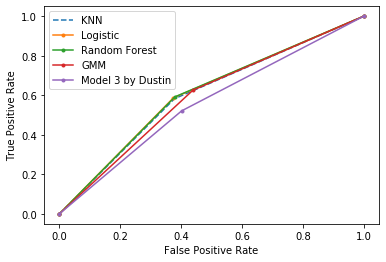

In [105]:
KNN_auc = roc_auc_score(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_k))
RF_auc = roc_auc_score(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_RF))
DT_auc = roc_auc_score(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_DT))
LR_auc = roc_auc_score(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_LR))
GMM_auc = roc_auc_score(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_GMM))
# Kaggle 3 submission - Dustin's minimalist model
mod3_auc = roc_auc_score(dev_labels, combine_model_preds(LR_model_pred_prb, DT_preds))
# summarize scores
print('KNN: ROC AUC=%.3f' % (KNN_auc))
print('Random Forest: ROC AUC=%.3f' % (RF_auc))
print('Decision Tree: ROC AUC=%.3f' % (DT_auc))
print('Logistic: ROC AUC=%.3f' % (LR_auc))
print('GMM: ROC AUC=%.3f' % (GMM_auc))
print('Model 3 by Dustin: ROC AUC=%.3f' % (mod3_auc))
# calculate roc curves
KNN_fpr, KNN_tpr, _ = roc_curve(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_k))
RF_fpr, RF_tpr, _ = roc_curve(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_RF))
#DT_fpr, DT_tpr, _ = roc_curve(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_DT))
LR_fpr, LR_tpr, _ = roc_curve(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_LR))
GMM_fpr, GMM_tpr, _ = roc_curve(dev_labels, combine_model_preds(Text_model_pred_prb, predictions_GMM))
mod3_fpr, mod3_tpr, _ = roc_curve(dev_labels, combine_model_preds(LR_model_pred_prb, DT_preds))
# plot the roc curve for the model
plt.plot(KNN_fpr, KNN_tpr, linestyle='--', label='KNN')
#plt.plot(DT_fpr, DT_tpr, marker='.', label='Decision Tree')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic')
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest')
plt.plot(GMM_fpr, GMM_tpr, marker='.', label='GMM')
plt.plot(mod3_fpr, mod3_tpr, marker='.', label='Model 3 by Dustin')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [46]:
## test data transformation
df_test['request_length'] = df_test.request_text_edit_aware.str.len()

visual_test = df_test['request_text_edit_aware'].apply(lambda x: len(visual.findall(x)))
df_test['includes_visuals'] = np.where(visual_test > 0,1,0)
df_test['request_title_text'] = df_test['request_title'] + df_test['request_text_edit_aware']
hyperlink_test = df_test['request_text_edit_aware'].apply(lambda x: len(hyperlink.findall(x)))
df_test['includes_hyperlink'] = np.where(hyperlink_test > 0,1,0)

word_count = np.zeros((df_test.shape[0],n_components))
for i in range(n_components):
    words_re = '|'.join(topic_feature_dict[i])
    words_re = "r'" + words_re + "'"
    for j, text in enumerate(df_test['request_title_text']):
        text = text.lower()
        text = re.sub(r'\_',' ',text)
        text = re.sub(r'[^\w\s]',' ',text)
        word_count[j, i] = pd.Series(text.split()).str.contains(words_re).sum()

word_count_df_test = pd.DataFrame(word_count, columns=list(['Topic1_count','Topic2_count', 'Topic3_count',
                                                       'Topic4_count', 'Topic5_count']))
df_test = pd.concat([df_test, word_count_df_test], axis=1)

Xtest = vectorizer.transform(df_test['request_text_edit_aware'])

req_polarity = [sia.polarity_scores(x) for x in df_test['request_text_edit_aware']]
sentiment_pos = [x['pos'] for x in req_polarity]
sentiment_neg = [x['neg'] for x in req_polarity]
sentiment_pos_neg = [(x['pos'], x['neg']) for x in req_polarity]
df_test['sentiment_bin'] = np.array([x[0]>x[1] for x in sentiment_pos_neg]).astype(int)

for i in range(n_components):
    df_test['Topic'+ str(i + 1) +'_dec'] = pd.qcut(df_test['Topic'+ str(i + 1) +'_count'].rank(method='first'), 
                                                   q = 10, labels = False)


In [47]:
clf_RF.fit(df_train[columns_for_modeling], train_labels)
predictions_ensemble = clf_RF.predict(df_test[columns_for_modeling])


In [48]:
df_prediction = df_test[['request_id']]
df_prediction['requester_received_pizza'] = np.where(predictions_ensemble == True,1,0)
df_prediction[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_RF.csv')

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
# test data predictions
pca_2d_test = pca.transform(df_test[columns_for_modeling])
prob_positive_test = gmm_positive.score_samples(pca_2d_test)
prob_negative_test = gmm_negative.score_samples(pca_2d_test)

# Label 1 if the probability of being positive is greater than the probability of being negative
# Otherwise label 0
pred_labels_test = np.where(prob_positive_test > prob_negative_test, 1, 0)


In [96]:
Text_model_alltrain = LogisticRegression(C=0.1, solver="liblinear", multi_class="auto", class_weight='balanced')
Text_model_alltrain.fit(X, train_labels)
Text_model_preds_test = Text_model_alltrain.predict(Xtest)
Text_model_pred_prb_test = Text_model_alltrain.predict_proba(Xtest)
#print(np.sum(positive_preds_49), np.sum(np.array(DT_preds_binary)), np.sum(np.array(DT_PLUS_LR_positive_preds)))

df_test['requester_received_pizza'] = combine_model_preds(Text_model_pred_prb_test, pred_labels_test)

kaggle_submission = df_test[['request_id', 'requester_received_pizza']].to_csv('kaggle_submission_GMM_tfidf.csv')

## Baseline & Modeling Results

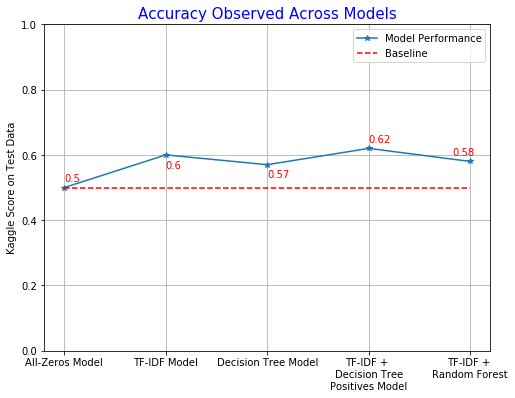

In [53]:
# Use the first cell to show summary of results
kaggle_submission_0_results = .5
kaggle_submission_1_results = .60
kaggle_submission_2_results = .57
kaggle_submission_3_results = .62
kaggle_submission_AC_results = .58

data = [kaggle_submission_0_results, kaggle_submission_1_results, kaggle_submission_2_results, kaggle_submission_3_results,
       kaggle_submission_AC_results]
labels = ['All-Zeros Model', 'TF-IDF Model', 'Decision Tree Model', 'TF-IDF + \nDecision Tree\nPositives Model',
          'TF-IDF + \nRandom Forest']

baseline = []
for p in data:
    baseline.append(.5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.grid() 
ax.plot(labels, data, label='Model Performance', marker='*')
ax.plot(baseline, label='Baseline', color='red', linestyle='--')
ax.set_ylim(0, 1)
ax.set_title('Accuracy Observed Across Models', color='blue', size=15)
ax.annotate(data[0], xy=(0, .52), color='red')
ax.annotate(data[1], xy=(1, .56), color='red')
ax.annotate(data[2], xy=(2, .53), color='red')
ax.annotate(data[3], xy=(3, .64), color='red')
ax.annotate(data[4], xy=(3.825, .6), color='red')
ax.set_ylabel('Kaggle Score on Test Data')
ax.legend()

## Next Steps

**Feature Engineering**
* Identify topics to assign to each text body (e.g. food, money, etc.) via clustering (unsupervised learning)
* Identify day of the week (e.g. weekday vs weekend differences)
* Identify which posts contain images and which don't
* Normalize feature ranges

**Modeling Additions and/or Enhancements**
* Boosting with decision trees
* Bagging to reduce bias
* Tuning hyperparameters (e.g., further pruning decision tree)
* Various ensemble approaches for final predicition
* Modeling approaches not yet tried - KNN, Naive Bayes, etc. 